# 필요한 라이브러리 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action = 'ignore')

import lightgbm as lgb
import gc


In [ ]:
base_path = '/content/drive/MyDrive/머신러닝 실습/jeju_data/'

train = pd.read_csv(base_path + "train.csv", encoding='UTF8')
test = pd.read_csv(base_path + "test.csv", encoding='UTF8')

# RAM용량 아끼끼

In [ ]:
to_int32 = ["base_date", "base_hour", "lane_count", "road_rating", "multi_linked", "connect_code", "road_type"]
to_float32 = ["vehicle_restricted", "height_restricted", "maximum_speed_limit", "weight_restricted", "target"]

for i in to_int32:
    train[i] = train[i].astype("int32")
for j in to_float32:
    train[j] = train[j].astype("float32")

# Pre-processing

In [ ]:
only_one_value = []
for i in train.columns[2:]:
    if len(train[i].value_counts()) <2:
        only_one_value.append(i)
len(only_one_value)

2

In [ ]:
print(train["vehicle_restricted"].value_counts())
print("---------------------------------------")
print(train["height_restricted"].value_counts())

0.0    4701217
Name: vehicle_restricted, dtype: int64
---------------------------------------
0.0    4701217
Name: height_restricted, dtype: int64


In [ ]:
# 확인된 해당 컬럼을 제거하겠습니다
train.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)
test.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)

In [ ]:
train.groupby(["base_date"])["target"].size()

base_date
20210901    19722
20210902    18809
20210903    19880
20210904    17998
20210905    17836
            ...  
20220727     9195
20220728     7601
20220729     5138
20220730     1845
20220731     5539
Name: target, Length: 281, dtype: int64

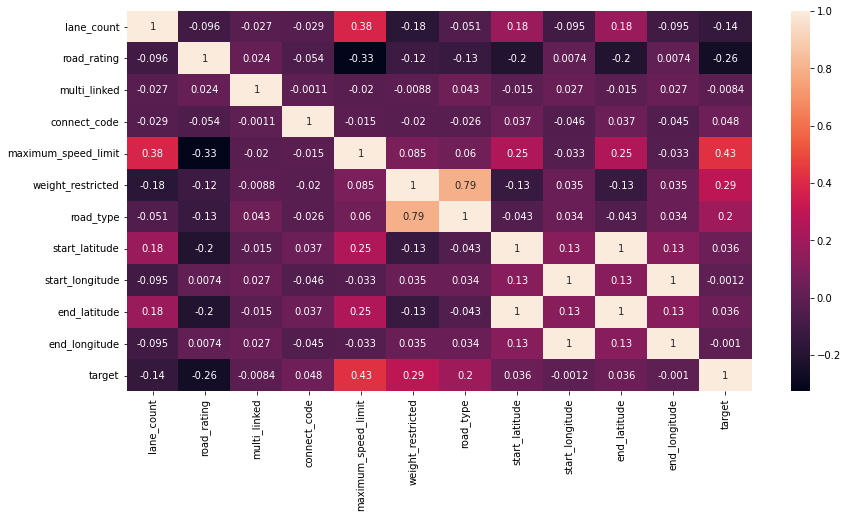

In [ ]:
# "base_date"와 "base_hour"는 상관관계를 분석하지 않을 것이기에 임시로 object로 변형하겠습니다
train[["base_date", "base_hour"]] = train[["base_date", "base_hour"]].astype(object)
plt.figure(figsize = (14,7))
sns.heatmap(train.corr(), annot = True)

# object로 변형하였던 "base_hour", "base_date"를 다시 int형으로 변형하겠습니다
train[["base_hour", "base_date"]] = train[["base_hour","base_date"]].astype("int32")

In [ ]:
train.maximum_speed_limit.value_counts()

60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: maximum_speed_limit, dtype: int64

In [ ]:
drop_road_name_index = train[train["road_name"] == "-"].index
temp_train = train.iloc[drop_road_name_index]
temp_train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
6,TRAIN_0000006,20220106,목,0,2,107,-,0,0,60.0,...,0,가동,33.418412,126.268029,없음,나동,33.414175,126.269378,없음,39.0
14,TRAIN_0000014,20220203,목,16,1,107,-,0,0,60.0,...,3,송목교,33.316913,126.624634,없음,송목교,33.317065,126.623867,없음,58.0
28,TRAIN_0000028,20220612,일,14,2,107,-,0,0,50.0,...,0,광평교차로,33.330822,126.354179,없음,금악,33.330673,126.354987,없음,59.0
30,TRAIN_0000030,20220623,목,6,2,107,-,0,0,80.0,...,0,일호유리,33.472276,126.418443,없음,상귀교차로,33.473390,126.409129,없음,75.0
31,TRAIN_0000031,20211028,목,15,1,107,-,0,0,60.0,...,3,남수교,33.337244,126.695809,없음,남수교,33.337398,126.696117,없음,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701204,TRAIN_4701204,20211001,금,19,1,107,-,0,0,60.0,...,0,한남교차로,33.325096,126.665698,없음,서중2교,33.331742,126.676431,없음,55.0
4701205,TRAIN_4701205,20220112,수,19,1,107,-,0,0,50.0,...,0,감귤창고,33.450215,126.920771,없음,수협,33.448689,126.916358,없음,23.0
4701208,TRAIN_4701208,20220323,수,19,2,107,-,0,0,80.0,...,3,제2태흥교,33.287356,126.736525,없음,제2태흥교,33.287582,126.737512,없음,61.0
4701212,TRAIN_4701212,20211104,목,16,1,107,-,0,0,50.0,...,0,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0


In [ ]:
print(temp_train["road_rating"].value_counts())
print(temp_train["weight_restricted"].value_counts())
print("----------------------------------")
print(train[(train["road_rating"] == 107) & (train["weight_restricted"] == 43200.0)]["road_name"].value_counts())
print(train[(train["road_rating"] == 107) & (train["weight_restricted"] == 32400.0)]["road_name"].value_counts())

107    569463
Name: road_rating, dtype: int64
0.0        481943
43200.0     68013
32400.0     19507
Name: weight_restricted, dtype: int64
----------------------------------
-      68013
중문로    11336
Name: road_name, dtype: int64
-      19507
산서로     7940
Name: road_name, dtype: int64


In [ ]:
# .loc로 값 대체하기 전의 수 = 569463
print(len(train[train["road_name"] == "-"]))
train.loc[(train["road_rating"] == 107) & (train["weight_restricted"] == 32400.0) & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["road_rating"] == 107) & (train["weight_restricted"] == 43200.0) & (train["road_name"] == "-"), "road_name"] = "중문로"

test.loc[(test["road_rating"] == 107) & (test["weight_restricted"] == 32400.0) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["road_rating"] == 107) & (test["weight_restricted"] == 43200.0) & (test["road_name"] == "-"), "road_name"] = "중문로"

# .loc로 값 대체한 이후의 수 = 481943
print(len(train[train["road_name"] == "-"]))

569463
481943


In [ ]:
# "-" 값 대체를 위한 탐색"
# 모든 값을 뽑으면 너무 길어지기에, 2개 값만을 출력합니다.
for i in train["start_node_name"].unique():
    if (len(train[(train["start_node_name"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["start_node_name"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["start_node_name"] == i)]["road_name"].value_counts())

---------------- 송목교 -------------------
중문로    10390
-       5183
Name: road_name, dtype: int64
---------------- 남수교 -------------------
중문로    10360
-       5156
Name: road_name, dtype: int64
---------------- 하귀입구 -------------------
일반국도12호선    10656
-            5190
Name: road_name, dtype: int64
---------------- 양계장 -------------------
-           5330
일반국도12호선    5329
Name: road_name, dtype: int64
---------------- 난산입구 -------------------
지방도1119호선    4923
-            3113
Name: road_name, dtype: int64
---------------- 영주교 -------------------
일반국도11호선    23909
-             472
Name: road_name, dtype: int64
---------------- 서중2교 -------------------
중문로    10380
-       5204
Name: road_name, dtype: int64
---------------- 천제이교 -------------------
-      10930
산서로    10706
Name: road_name, dtype: int64
---------------- 하나로교 -------------------
중문로    10578
-       5282
Name: road_name, dtype: int64
---------------- 신하교 -------------------
중문로    10390
-       5205
Name: road_name, 

In [ ]:
print(len(train[train["road_name"] == "-"]))

train.loc[(train["start_node_name"] == "송목교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "남수교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "하귀입구") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["start_node_name"] == "양계장") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["start_node_name"] == "난산입구") & (train["road_name"] == "-"), "road_name"] = "지방도1119호선"
train.loc[(train["start_node_name"] == "영주교") & (train["road_name"] == "-"), "road_name"] = "일반국도11호선"
train.loc[(train["start_node_name"] == "서중2교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "천제이교") & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["start_node_name"] == "하나로교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "신하교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "야영장") & (train["road_name"] == "-"), "road_name"] = "관광단지1로"
train.loc[(train["start_node_name"] == "월계교") & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["start_node_name"] == "서울이용원") & (train["road_name"] == "-"), "road_name"] = "태평로"
train.loc[(train["start_node_name"] == "김녕교차로") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["start_node_name"] == "어도초등교") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["start_node_name"] == "광삼교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "오렌지농원") & (train["road_name"] == "-"), "road_name"] = "일반국도11호선"
train.loc[(train["start_node_name"] == "우사") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["start_node_name"] == "서귀포시산림조합") & (train["road_name"] == "-"), "road_name"] = "지방도1136호선"
train.loc[(train["start_node_name"] == "성읍삼거리") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"

test.loc[(test["start_node_name"] == "송목교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "남수교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "하귀입구") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["start_node_name"] == "양계장") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["start_node_name"] == "난산입구") & (test["road_name"] == "-"), "road_name"] = "지방도1119호선"
test.loc[(test["start_node_name"] == "영주교") & (test["road_name"] == "-"), "road_name"] = "일반국도11호선"
test.loc[(test["start_node_name"] == "서중2교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "천제이교") & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["start_node_name"] == "하나로교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "신하교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "야영장") & (test["road_name"] == "-"), "road_name"] = "관광단지1로"
test.loc[(test["start_node_name"] == "월계교") & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["start_node_name"] == "서울이용원") & (test["road_name"] == "-"), "road_name"] = "태평로"
test.loc[(test["start_node_name"] == "김녕교차로") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["start_node_name"] == "어도초등교") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["start_node_name"] == "광삼교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "오렌지농원") & (test["road_name"] == "-"), "road_name"] = "일반국도11호선"
test.loc[(test["start_node_name"] == "우사") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["start_node_name"] == "서귀포시산림조합") & (test["road_name"] == "-"), "road_name"] = "지방도1136호선"
test.loc[(test["start_node_name"] == "성읍삼거리") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"

print(len(train[train["road_name"] == "-"]))

481943
379668


In [ ]:
# "-" 값 대체를 위한 탐색"
for i in train["end_node_name"].unique():
    if (len(train[(train["end_node_name"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["end_node_name"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["end_node_name"] == i)]["road_name"].value_counts())

---------------- 남수교 -------------------
중문로    10360
-       5187
Name: road_name, dtype: int64
---------------- 농협주유소 -------------------
-      8053
산서로    5089
Name: road_name, dtype: int64
---------------- 난산입구 -------------------
지방도1119호선    4978
-            2946
Name: road_name, dtype: int64
---------------- 성읍삼거리 -------------------
일반국도16호선    5030
-           4670
Name: road_name, dtype: int64
---------------- 김녕교차로 -------------------
일반국도12호선    5281
-           3266
Name: road_name, dtype: int64
---------------- 한남교차로 -------------------
중문로    5204
-      5198
Name: road_name, dtype: int64
---------------- 서울이용원 -------------------
태평로    11653
-       1417
Name: road_name, dtype: int64
---------------- 하귀입구 -------------------
일반국도12호선    10661
-            5144
Name: road_name, dtype: int64
---------------- 우사 -------------------
일반국도16호선    7677
-           4784
Name: road_name, dtype: int64
---------------- 어도초등교 -------------------
-           7053
일반국도16호선    5135

In [ ]:
print(len(train[train["road_name"] == "-"]))

train.loc[(train["end_node_name"] == "남수교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_node_name"] == "농협주유소") & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["end_node_name"] == "난산입구") & (train["road_name"] == "-"), "road_name"] = "지방도1119호선"
train.loc[(train["end_node_name"] == "성읍삼거리") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["end_node_name"] == "김녕교차로") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["end_node_name"] == "한남교차로") & (train["road_name"] == "-"), "road_name"] = "서중2교"
train.loc[(train["end_node_name"] == "서울이용원") & (train["road_name"] == "-"), "road_name"] = "태평로"
train.loc[(train["end_node_name"] == "하귀입구") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["end_node_name"] == "어도초등교") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["end_node_name"] == "월계교") & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["end_node_name"] == "양계장") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["end_node_name"] == "하나로교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_node_name"] == "광삼교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_node_name"] == "수간교차로") & (train["road_name"] == "-"), "road_name"] = "양계장"
train.loc[(train["end_node_name"] == "난산사거리") & (train["road_name"] == "-"), "road_name"] = "난산입구"
train.loc[(train["end_node_name"] == "서중2교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_node_name"] == "서귀포시산림조합") & (train["road_name"] == "-"), "road_name"] = "지방도1136호선"
train.loc[(train["end_node_name"] == "옹포사거리") & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["end_node_name"] == "진은교차로") & (train["road_name"] == "-"), "road_name"] = "하나로교"

test.loc[(test["end_node_name"] == "남수교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_node_name"] == "농협주유소") & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["end_node_name"] == "난산입구") & (test["road_name"] == "-"), "road_name"] = "지방도1119호선"
test.loc[(test["end_node_name"] == "성읍삼거리") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["end_node_name"] == "김녕교차로") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["end_node_name"] == "한남교차로") & (test["road_name"] == "-"), "road_name"] = "서중2교"
test.loc[(test["end_node_name"] == "서울이용원") & (test["road_name"] == "-"), "road_name"] = "태평로"
test.loc[(test["end_node_name"] == "하귀입구") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["end_node_name"] == "어도초등교") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["end_node_name"] == "월계교") & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["end_node_name"] == "양계장") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["end_node_name"] == "하나로교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_node_name"] == "광삼교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_node_name"] == "수간교차로") & (test["road_name"] == "-"), "road_name"] = "양계장"
test.loc[(test["end_node_name"] == "난산사거리") & (test["road_name"] == "-"), "road_name"] = "난산입구"
test.loc[(test["end_node_name"] == "서중2교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_node_name"] == "서귀포시산림조합") & (test["road_name"] == "-"), "road_name"] = "지방도1136호선"
test.loc[(test["end_node_name"] == "옹포사거리") & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["end_node_name"] == "진은교차로") & (test["road_name"] == "-"), "road_name"] = "하나로교"

print(len(train[train["road_name"] == "-"]))

379668
282684


In [ ]:
# 소숫점 문제상 출력된 값을 그대로 사용한다면 값을 대체할 수 없는 문제가 있습니다.
# 이를 해결하기 위해서 소숫점의 자릿수를 제한하겠습니다.
print(train["start_latitude"].nunique(),train["start_longitude"].nunique(), train["end_latitude"].nunique(), train["end_longitude"].nunique())

# 7번째자리에서 반올림 할 경우 train에서의 고윳값 갯수가 변하지 않습니다
train[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]] = train[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x: round(x, 6))
test[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]] = test[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x: round(x, 6))

print(train["start_latitude"].nunique(),train["start_longitude"].nunique(), train["end_latitude"].nunique(), train["end_longitude"].nunique())

586 586 586 586
586 586 586 586


In [ ]:
for i in train["start_latitude"].unique():
    if (len(train[(train["start_latitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["start_latitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["start_latitude"] == i)]["road_name"].value_counts())


---------------- 33.409416 -------------------
-      3321
월계교    3184
Name: road_name, dtype: int64
---------------- 33.402546 -------------------
-            2953
지방도1119호선    2946
Name: road_name, dtype: int64
---------------- 33.471164 -------------------
-           5334
일반국도12호선    5331
Name: road_name, dtype: int64
---------------- 33.411255 -------------------
-      7382
월계교    4338
Name: road_name, dtype: int64
---------------- 33.405319 -------------------
산서로    4821
-      4159
Name: road_name, dtype: int64
---------------- 33.322018 -------------------
서중2교    5198
-       2396
Name: road_name, dtype: int64
---------------- 33.325096 -------------------
중문로    5187
-      5187
Name: road_name, dtype: int64
---------------- 33.408431 -------------------
-      8441
산서로    4777
Name: road_name, dtype: int64
---------------- 33.284189 -------------------
중문로    5306
-      5288
Name: road_name, dtype: int64
---------------- 33.47339 -------------------
-      5344
양계장    53

In [ ]:
print(len(train[train["road_name"] == "-"]))

train.loc[(train["start_latitude"] == 33.409416) & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["start_latitude"] == 33.402546) & (train["road_name"] == "-"), "road_name"] = "지방도1119호선"
train.loc[(train["start_latitude"] == 33.471164) & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["start_latitude"] == 33.411255) & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["start_latitude"] == 33.405319) & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["start_latitude"] == 33.322018) & (train["road_name"] == "-"), "road_name"] = "서중2교"
train.loc[(train["start_latitude"] == 33.325096) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_latitude"] == 33.408431) & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["start_latitude"] == 33.284189) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_latitude"] == 33.47339) & (train["road_name"] == "-"), "road_name"] = "양계장"

test.loc[(test["start_latitude"] == 33.409416) & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["start_latitude"] == 33.402546) & (test["road_name"] == "-"), "road_name"] = "지방도1119호선"
test.loc[(test["start_latitude"] == 33.471164) & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["start_latitude"] == 33.411255) & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["start_latitude"] == 33.405319) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["start_latitude"] == 33.322018) & (test["road_name"] == "-"), "road_name"] = "서중2교"
test.loc[(test["start_latitude"] == 33.325096) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_latitude"] == 33.408431) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["start_latitude"] == 33.284189) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_latitude"] == 33.47339) & (test["road_name"] == "-"), "road_name"] = "양계장"

print(len(train[train["road_name"] == "-"]))

282684
232879


In [ ]:
# "-" 값 대체를 위한 탐색"
for i in train["end_latitude"].unique():
    if (len(train[(train["end_latitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["end_latitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["end_latitude"] == i)]["road_name"].value_counts())


---------------- 33.47339 -------------------
-           5338
일반국도12호선    5334
Name: road_name, dtype: int64
---------------- 33.358358 -------------------
-           4784
일반국도16호선    2251
Name: road_name, dtype: int64
---------------- 33.412573 -------------------
-      4389
월계교    4199
Name: road_name, dtype: int64
---------------- 33.244882 -------------------
-      5528
산서로    5415
Name: road_name, dtype: int64
---------------- 33.322018 -------------------
중문로    5187
-      2493
Name: road_name, dtype: int64


In [ ]:
train.loc[(train["end_latitude"] == 33.47339) & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["end_latitude"] == 33.358358) & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["end_latitude"] == 33.412573) & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["end_latitude"] == 33.244882) & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["end_latitude"] == 33.322018) & (train["road_name"] == "-"), "road_name"] = "중문로"

test.loc[(test["end_latitude"] == 33.47339) & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["end_latitude"] == 33.358358) & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["end_latitude"] == 33.412573) & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["end_latitude"] == 33.244882) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["end_latitude"] == 33.322018) & (test["road_name"] == "-"), "road_name"] = "중문로"

In [ ]:
# "-" 값 대체를 위한 탐색"
for i in train["start_longitude"].unique():
    if (len(train[(train["start_longitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["start_longitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["start_longitude"] == i)]["road_name"].value_counts())

---------------- 126.259693 -------------------
월계교    4389
-      4223
Name: road_name, dtype: int64


In [ ]:
train.loc[(train["start_longitude"] == 126.259693) & (train["road_name"] == "-"), "road_name"] = "월계교"

test.loc[(test["start_longitude"] == 126.259693) & (test["road_name"] == "-"), "road_name"] = "월계교"

In [ ]:
# "-" 값 대체를 위한 탐색"
for i in train["end_longitude"].unique():
    if (len(train[(train["end_longitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["end_longitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["end_longitude"] == i)]["road_name"].value_counts())

---------------- 126.261797 -------------------
-      4438
월계교    4223
Name: road_name, dtype: int64


In [ ]:
train.loc[(train["end_longitude"] == 126.261797) & (train["road_name"] == "-"), "road_name"] = "월계교"

test.loc[(test["end_longitude"] == 126.261797) & (test["road_name"] == "-"), "road_name"] = "월계교"

In [ ]:
print(len(train[train["road_name"] == "-"]))

201686


In [ ]:
# 추가 탐색 - 종료지점을 중심으로
temp_train = train.groupby(["end_longitude", "end_latitude", "lane_count"])[["road_name"]].sum()
temp_train

temp_train1 = temp_train.agg({"road_name": pd.Series.mode})
temp_train1

long_lat = []

for i in range(len(temp_train1)):
    if "-" in temp_train1["road_name"].iloc[i][0]:
        #print(temp_train1.index[i])
        long_lat.append(temp_train1.index[i])

for i in range(len(long_lat)):
    if len(train[(train["end_longitude"] == long_lat[i][0]) & (train["end_latitude"] == long_lat[i][1])]["road_name"].value_counts()) > 1:
        print(train[(train["end_longitude"] == long_lat[i][0]) & (train["end_latitude"] == long_lat[i][1]) & (train["lane_count"] == long_lat[i][2])]["road_name"].value_counts())
        print(long_lat[i][0], long_lat[i][1], long_lat[i][2])
        print("------------------------------")

-      4395
산서로    4159
월계교    3321
Name: road_name, dtype: int64
126.257313 33.411255 2
------------------------------
-      5928
중문로    5881
Name: road_name, dtype: int64
126.414236 33.255215 2
------------------------------
-      6057
애조로    6048
Name: road_name, dtype: int64
126.456384 33.465863 2
------------------------------


In [ ]:
train.loc[(train["end_longitude"] == 126.414236) & (train["end_latitude"] == 33.255215) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_longitude"] == 126.456384) & (train["end_latitude"] == 33.465863) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "애조로"

test.loc[(test["end_longitude"] == 126.414236) & (test["end_latitude"] == 33.255215) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_longitude"] == 126.456384) & (test["end_latitude"] == 33.465863) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "애조로"

In [ ]:
# 추가 탐색 - 시작지점을 중심으로
temp_train = train.groupby(["start_longitude", "start_latitude", "lane_count"])[["road_name"]].sum()
temp_train

temp_train1 = temp_train.agg({"road_name": pd.Series.mode})
temp_train1

long_lat = []

for i in range(len(temp_train1)):
    if "-" in temp_train1["road_name"].iloc[i][0]:
        #print(temp_train1.index[i])
        long_lat.append(temp_train1.index[i])

for i in range(len(long_lat)):
    if len(train[(train["start_longitude"] == long_lat[i][0]) & (train["start_latitude"] == long_lat[i][1])]["road_name"].value_counts()) > 1:
        print(train[(train["start_longitude"] == long_lat[i][0]) & (train["start_latitude"] == long_lat[i][1]) & (train["lane_count"] == long_lat[i][2])]["road_name"].value_counts())
        print(long_lat[i][0], long_lat[i][1], long_lat[i][2])
        print("------------------------------")

월계교    4438
-      4360
Name: road_name, dtype: int64
126.262739 33.415854 2
------------------------------
중문로    5928
-      5853
Name: road_name, dtype: int64
126.413687 33.255431 2
------------------------------
-    5899
Name: road_name, dtype: int64
126.414236 33.255215 2
------------------------------
애조로    6057
-      6034
Name: road_name, dtype: int64
126.454583 33.466433 2
------------------------------
애조로    6044
-      6034
Name: road_name, dtype: int64
126.456384 33.465863 2
------------------------------


In [ ]:
train.loc[(train["start_longitude"] == 126.262739) & (train["start_latitude"] == 33.415854) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["start_longitude"] == 126.413687) & (train["start_latitude"] == 33.255431) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_longitude"] == 126.454583) & (train["start_latitude"] == 33.466433) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "애조로"
train.loc[(train["start_longitude"] == 126.456384) & (train["start_latitude"] == 33.465863) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "애조로"

test.loc[(test["start_longitude"] == 126.262739) & (test["start_latitude"] == 33.415854) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["start_longitude"] == 126.413687) & (test["start_latitude"] == 33.255431) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_longitude"] == 126.454583) & (test["start_latitude"] == 33.466433) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "애조로"
test.loc[(test["start_longitude"] == 126.456384) & (test["start_latitude"] == 33.465863) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "애조로"

In [ ]:
print(len(train[train["road_name"] == "-"]))

167420


In [ ]:
def set_binned_time(x): # 23시 ~ 오전 6시 & 오전 7시~ 22시
    if 7 <= x <= 22:
        time = "traffic"
    elif 23 <= x <= 24 :
        time = "resttime"
    elif 0 <= x <= 6 :
        time = "resttime"
    else: # 0 ~ 24 이외에 다른 값이 적용된 경우
        time = None
    return time

In [ ]:
train["work_or_rest_or_other"] = train["base_hour"].apply(set_binned_time)
test["work_or_rest_or_other"] = test["base_hour"].apply(set_binned_time)

In [ ]:
#시간 대별로 나눔
train.work_or_rest_or_other.value_counts()

traffic     3319387
resttime    1381830
Name: work_or_rest_or_other, dtype: int64

In [ ]:
def season(x) :
    if x in [3, 4, 5, 6] :
        return 0
    elif x in [7, 8, 9] :
        return 1
    elif x in [10, 11] :
        return 2
    else :
        return 3

train['season'] = train['base_date'].apply(season)
test['season'] = test['base_date'].apply(season)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Labelling

In [ ]:
# 범주형 데이터에 라벨인코더 사용
str_col = ["day_of_week", "road_name", "start_node_name", "end_node_name",
           "start_turn_restricted", "end_turn_restricted", "weight_restricted", "road_rating",
           "road_type", "work_or_rest_or_other","season"]

for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [ ]:
to_int8 = ["day_of_week","weight_restricted", "base_hour", "lane_count", "road_rating", 
           "road_name","road_type", "start_turn_restricted", "end_turn_restricted", 
           "maximum_speed_limit", "work_or_rest_or_other","season"]
to_int16 = ["start_node_name", "end_node_name"]
to_int32 = ["base_date"]

for i in to_int8:
    train[i] = train[i].astype("int8")
for j in to_int16:
    train[j] = train[j].astype("int16")
for k in to_int32:
    train[k] = train[k].astype("int32")

In [ ]:
train_copy = train
test_copy = test

In [ ]:
train_copy

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,work_or_rest_or_other,season
0,TRAIN_0000000,20220623,1,17,1,1,50,0,0,60,...,33.427747,126.662612,0,386,33.427749,126.662335,0,52.0,1,0
1,TRAIN_0000001,20220728,1,21,2,0,38,0,0,60,...,33.500730,126.529107,1,2,33.504811,126.526240,0,30.0,1,0
2,TRAIN_0000002,20211010,4,7,2,0,40,0,0,80,...,33.279145,126.368598,0,179,33.280072,126.362147,0,61.0,1,0
3,TRAIN_0000003,20220311,0,13,2,2,61,0,0,50,...,33.246081,126.567204,0,203,33.245565,126.566228,0,20.0,1,0
4,TRAIN_0000004,20211005,6,8,2,0,39,0,0,80,...,33.462214,126.326551,0,269,33.462677,126.330152,0,38.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,1,16,1,2,0,0,0,50,...,33.422145,126.278125,0,42,33.420955,126.273750,0,20.0,1,0
4701213,TRAIN_4701213,20220331,1,2,2,2,46,0,0,80,...,33.472505,126.424368,0,31,33.472525,126.424890,0,65.0,0,0
4701214,TRAIN_4701214,20220613,3,22,2,0,39,0,0,60,...,33.447183,126.912579,0,214,33.444121,126.912948,0,30.0,1,0
4701215,TRAIN_4701215,20211020,2,2,2,0,41,0,0,80,...,33.443596,126.431817,0,23,33.444996,126.433332,0,73.0,0,0


In [ ]:
Y_train = train_copy['target']
X_train = train_copy.drop(['id','multi_linked','connect_code','target','base_date'] , axis =1 )
X_test = test_copy.drop(['id','multi_linked','connect_code','base_date'] , axis = 1)

In [ ]:
train_copy

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,work_or_rest_or_other,season
0,TRAIN_0000000,20220623,1,17,1,1,50,0,0,60,...,33.427747,126.662612,0,386,33.427749,126.662335,0,52.0,1,0
1,TRAIN_0000001,20220728,1,21,2,0,38,0,0,60,...,33.500730,126.529107,1,2,33.504811,126.526240,0,30.0,1,0
2,TRAIN_0000002,20211010,4,7,2,0,40,0,0,80,...,33.279145,126.368598,0,179,33.280072,126.362147,0,61.0,1,0
3,TRAIN_0000003,20220311,0,13,2,2,61,0,0,50,...,33.246081,126.567204,0,203,33.245565,126.566228,0,20.0,1,0
4,TRAIN_0000004,20211005,6,8,2,0,39,0,0,80,...,33.462214,126.326551,0,269,33.462677,126.330152,0,38.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,1,16,1,2,0,0,0,50,...,33.422145,126.278125,0,42,33.420955,126.273750,0,20.0,1,0
4701213,TRAIN_4701213,20220331,1,2,2,2,46,0,0,80,...,33.472505,126.424368,0,31,33.472525,126.424890,0,65.0,0,0
4701214,TRAIN_4701214,20220613,3,22,2,0,39,0,0,60,...,33.447183,126.912579,0,214,33.444121,126.912948,0,30.0,1,0
4701215,TRAIN_4701215,20211020,2,2,2,0,41,0,0,80,...,33.443596,126.431817,0,23,33.444996,126.433332,0,73.0,0,0


# Optuna

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   day_of_week            int8   
 1   base_hour              int8   
 2   lane_count             int8   
 3   road_rating            int8   
 4   road_name              int8   
 5   maximum_speed_limit    int8   
 6   weight_restricted      int8   
 7   road_type              int8   
 8   start_node_name        int16  
 9   start_latitude         float64
 10  start_longitude        float64
 11  start_turn_restricted  int8   
 12  end_node_name          int16  
 13  end_latitude           float64
 14  end_longitude          float64
 15  end_turn_restricted    int8   
 16  work_or_rest_or_other  int8   
 17  season                 int8   
dtypes: float64(4), int16(2), int8(12)
memory usage: 215.2 MB


In [ ]:
Y_train

0          52.0
1          30.0
2          61.0
3          20.0
4          38.0
           ... 
4701212    20.0
4701213    65.0
4701214    30.0
4701215    73.0
4701216    35.0
Name: target, Length: 4701217, dtype: float32

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291241 entries, 0 to 291240
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   day_of_week            291241 non-null  int64  
 1   base_hour              291241 non-null  int64  
 2   lane_count             291241 non-null  int64  
 3   road_rating            291241 non-null  int64  
 4   road_name              291241 non-null  int64  
 5   maximum_speed_limit    291241 non-null  float64
 6   weight_restricted      291241 non-null  int64  
 7   road_type              291241 non-null  int64  
 8   start_node_name        291241 non-null  int64  
 9   start_latitude         291241 non-null  float64
 10  start_longitude        291241 non-null  float64
 11  start_turn_restricted  291241 non-null  int64  
 12  end_node_name          291241 non-null  int64  
 13  end_latitude           291241 non-null  float64
 14  end_longitude          291241 non-nu

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 41.0 MB/s 
     |████████████████████████████████| 81 kB 9.8 MB/s 
     |████████████████████████████████| 209 kB 79.5 MB/s 
     |████████████████████████████████| 78 kB 7.8 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 112 kB 100.1 MB/s 
     |████████████████████████████████| 147 kB 103.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=6a89bd634a2302dd7015e78577a8c7b917b62746aa239b64fb934a1c0c00a42b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
from sklearn.model_selection import StratifiedKFold as kfold
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
import optuna
from sklearn.model_selection import KFold
from functools import partial

In [ ]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = trial.suggest_int('n_estimators', 200, 500)
    max_depth = trial.suggest_int('max_depth', 5, 8)
    max_features = trial.suggest_float('max_features', 0.7, 0.9)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 8, 12)
    min_samples_split = trial.suggest_int('min_samples_split', 8, 16)   
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 max_features=max_features,
                                 min_samples_leaf=min_samples_leaf,
                                 min_samples_split=min_samples_split)
    
    
    # K-Fold Cross validation을 구현합니다.
    from sklearn.model_selection import StratifiedKFold
    kf = kfold(n_splits = k, shuffle = True, random_state = 42)
    split = kf.split(X_train, Y_train)
    results = []
    
    for train, test in split:


      x_train, x_val, y_train, y_val = X_train.iloc[train], X_train.iloc[test], Y_train.iloc[train], Y_train.iloc[test]    
      model.fit(X_train, y_train)
    
      pred = model.predict(x_val)
      result = mean_absolute_error(pred, y_val)

      results.append(result)

      return np.mean(results)	


In [ ]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=Y_train, K=K)

study1 = optuna.create_study(direction="maximize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study1.optimize(opt_func, n_trials=30)

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

In [ ]:
import optuna

from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [ ]:
def RF_objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 10)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 1000)
    n_estimators =  trial.suggest_int('n_estimators', 100, 500)
   
    model = RandomForestRegressor(max_depth = max_depth, max_leaf_nodes = max_leaf_nodes,n_estimators = n_estimators,n_jobs=2,random_state=2022)

    
    model.fit(train_X, train_y)    
    pred = 

    return MAE_mean
    

In [ ]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

In [ ]:
train_X = train_copy.drop(['id','multi_linked','connect_code','target'], axis = 1)
train_y = train_copy.loc[:,'target']
test_X = test_copy.drop(['id','multi_linked','connect_code'], axis =1 )

In [ ]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=10,min_samples_split=10, random_state=2022)
model.fit(train_X, train_y)

RandomForestRegressor(min_samples_leaf=10, min_samples_split=10,
                      n_estimators=40, random_state=2022)

In [ ]:
# 트리 전체 중요도 저장

fi = train_X.iloc[0:0]

for i in range(40):
  fi.loc[i] = model.estimators_[i].feature_importances_
fi

,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,work_or_rest_or_other,season
0,0.026609,0.007722,0.033415,0.004782,0.083453,0.077511,0.246827,0.004962,0.003272,0.029444,0.033447,0.072233,0.002293,0.034719,0.103565,0.188542,0.000584,0.046621,0.0
1,0.026454,0.007739,0.033420,0.003544,0.081548,0.082282,0.247189,0.005546,0.003452,0.026802,0.028405,0.073262,0.001541,0.038869,0.102078,0.189358,0.002080,0.046431,0.0
2,0.026854,0.007777,0.033108,0.003022,0.085277,0.074915,0.244783,0.005734,0.003134,0.028467,0.034296,0.046574,0.000991,0.030357,0.107837,0.217946,0.002249,0.046680,0.0
3,0.026758,0.007896,0.034221,0.006476,0.087361,0.071413,0.246658,0.005669,0.003786,0.027584,0.032212,0.065661,0.001266,0.031572,0.103275,0.200597,0.001922,0.045673,0.0
4,0.026804,0.007848,0.034320,0.002191,0.088946,0.073452,0.245954,0.006509,0.003813,0.027887,0.026396,0.070848,0.001107,0.031373,0.105533,0.199239,0.002084,0.045697,0.0
5,0.026367,0.007887,0.038175,0.002262,0.086446,0.079113,0.252968,0.000970,0.003674,0.027012,0.086470,0.065231,0.000864,0.033807,0.045424,0.200988,0.000529,0.041812,0.0
6,0.026967,0.007666,0.033734,0.003409,0.085862,0.076583,0.245492,0.004888,0.003695,0.023355,0.029739,0.070913,0.002040,0.032371,0.102510,0.202303,0.002315,0.046161,0.0
7,0.026974,0.007690,0.033769,0.004837,0.087455,0.074798,0.244478,0.005385,0.003949,0.030452,0.030012,0.069490,0.002678,0.030870,0.098169,0.201956,0.000931,0.046105,0.0
8,0.026792,0.007744,0.032949,0.002719,0.086968,0.075457,0.244964,0.005728,0.003755,0.027973,0.029579,0.077052,0.001364,0.033215,0.097928,0.196357,0.002369,0.047089,0.0
9,0.026974,0.007756,0.033744,0.003114,0.087639,0.073763,0.245158,0.005118,0.004126,0.023630,0.031634,0.084965,0.001632,0.029332,0.110203,0.182761,0.002268,0.046182,0.0


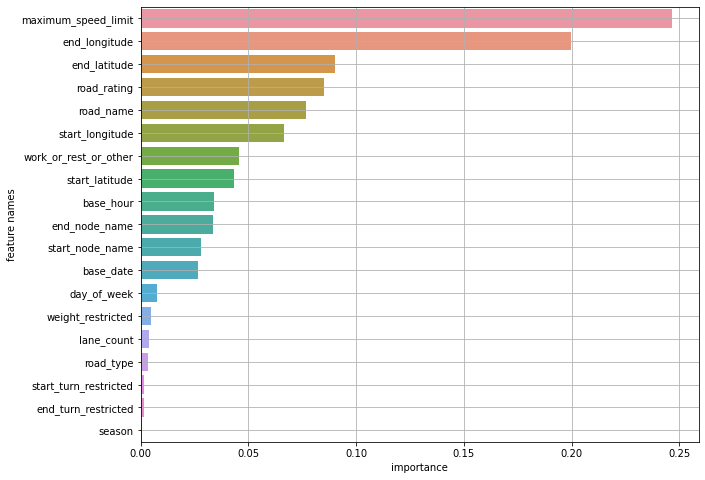

In [ ]:
result = plot_feature_importance(model.feature_importances_, list(train_X))

In [ ]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)

(4701217, 19)
(4701217,)
(291241, 19)


# feature importance 에서 확인 하면 maximum_speed_limit이 중요 하다는 걸 확인 
# maximum_speed_limit을 기준으로 모델 학습해서 결과를 합

In [ ]:
for i in range(30,90,10):
    if i==40:
        continue
    else:
        globals()[f'train_X{i}'] = train_X.loc[train_X['maximum_speed_limit']==i]

In [ ]:
# 튜팅된 Parameter를 각 모델에 부여
for i in range(30,90,10):
    if i==40:
        continue
    elif i==30:
        n_train = eval(f'train_X{i}')
        n_y_train = train_y[eval(f'train_X{i}').index]
        globals()[f'xgb_{i}'] =  RandomForestRegressor(n_estimators=40, min_samples_leaf=10,min_samples_split=10, random_state=2022).fit(n_train, n_y_train)
    elif i==50:
        n_train = eval(f'train_X{i}')
        n_y_train = train_y[eval(f'train_X{i}').index]
        globals()[f'xgb_{i}'] =  RandomForestRegressor(n_estimators=40, min_samples_leaf=10,min_samples_split=10, random_state=2022).fit(n_train, n_y_train)
    elif i==60:
        n_train = eval(f'train_X{i}')
        n_y_train = train_y[eval(f'train_X{i}').index]
        globals()[f'xgb_{i}'] =  RandomForestRegressor(n_estimators=40, min_samples_leaf=10,min_samples_split=10, random_state=2022).fit(n_train, n_y_train)
    elif i==70:
        n_train = eval(f'train_X{i}')
        n_y_train = train_y[eval(f'train_X{i}').index]
        globals()[f'xgb_{i}'] =  RandomForestRegressor(n_estimators=40, min_samples_leaf=10,min_samples_split=10, random_state=2022).fit(n_train, n_y_train)
    elif i==80:
        n_train = eval(f'train_X{i}')
        n_y_train = train_y[eval(f'train_X{i}').index]
        globals()[f'xgb_{i}'] =  RandomForestRegressor(n_estimators=40, min_samples_leaf=10,min_samples_split=10, random_state=2022).fit(n_train, n_y_train)

In [ ]:
# Limit Speed 별 모델로 test data set의 target 예측
for i in range(30,90,10):
    if i==40:
        continue
    else:
        globals()[f'pred_xgb_{i}'] = eval(f'xgb_{i}').predict(test_X.loc[test_X['maximum_speed_limit']==i])

In [ ]:
# 모델 예측값을 각각 대입
for i in range(30,90,10):
    if i==40:
        continue
    else:
        test_X.loc[test_X['maximum_speed_limit']==i, 'pred'] = eval(f'pred_xgb_{i}')

In [ ]:
practice6 = pd.read_csv('/content/drive/MyDrive/머신러닝 실습/jeju_data/sample_submission.csv')

In [ ]:
pred = test_X['pred']

In [ ]:
pred

0         25.847499
1         42.381896
2         68.460916
3         38.661504
4         42.701961
            ...    
291236    46.913315
291237    51.150752
291238    22.773010
291239    22.103404
291240    48.015524
Name: pred, Length: 291241, dtype: float64

In [ ]:
pred.reset_index(inplace = True, drop = True)

In [ ]:
practice6['target'] = pred
practice6.to_csv(f"./practice6.csv", index = False )

practice6

,id,target
0,TEST_000000,25.847499
1,TEST_000001,42.381896
2,TEST_000002,68.460916
3,TEST_000003,38.661504
4,TEST_000004,42.701961
...,...,...
291236,TEST_291236,46.913315
291237,TEST_291237,51.150752
291238,TEST_291238,22.773010
291239,TEST_291239,22.103404
